# How to read MDF files in Python

In this notebook an example is given on how to read a MDF file using the Python *mlab_mdfreader* module. First this is done by just reading all the data at once. Next it is demonstrated how to make a selection of channels to read such that the data reading time can reduced significantly. 

But first let's start with importing some modules and setting up the information logger. 

In [1]:
import os
import sys
import matplotlib.pyplot as plt
if ".." not in sys.path:
    sys.path.append("..")  # required to be able to run the notebook in the explorer

import mlab_mdfreader.mdf_parser as mdf
from hmc_utils.misc import (create_logger, print_banner, Timer)

file_name = "data/AMS_BALDER_110225T233000_UTC222959.mdf"
if not os.path.exists(file_name):
    file_name = os.path.join("..", file_name)

logger = create_logger(console_log_format_clean=True)


We are ready the read the mdf date by just creating a *MDFParser* object with the *file_name* as input. We put the *Timer()* around the reader only to show how long the reader needs to import all the data, but this is not required

In [2]:

logger.info("Reading the mdf file {}".format(file_name))
# add the Timer only in order to show how long the reader takes
with Timer(units="s", name="MDFParser") as timer:
    mdf_obj = mdf.MDFParser(mdf_file=file_name)
logger.info("Done")

mdf_obj.data.info()


Reading the mdf file ..\data/AMS_BALDER_110225T233000_UTC222959.mdf
Elapsed time         MDFParser            :         34 s
Done
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2011-02-25 23:30:00 to 2011-02-25 23:59:59.960000
Columns: 115 entries, GPS_GGAQ to GPS_LongitudeDez
dtypes: float64(94), int16(3), int32(11), uint16(6), uint32(1)
memory usage: 35.4 MB


The reading of a MDF file takes quite some time due to the binary conversion which needs to take place under the hood. In this case the reading time was 34 s. After we are done reading, all the data is stored in a pandas *DataFrame* which can be refered to as `mdf_obj.data`. We currently have loaded all 116 columns. 

We can have a look at the contents of the columns by using the *make_report()* method. This will show a table to screen with five columns:
1. A counter refering to the index of the table
2. An index refering to the position of the channel in the DataFrame
3. A flag *Loaded* to show if this channel has been loaded (now all set to true)
4. The (unique) record name also used to refer to a channel in the DataFrame.
5. The label of the record giving a small description of the channel.


In [3]:
names = mdf_obj.make_report()

cnt index Loaded : Name                                               : Label
--- ----- ------ : -------------------------------------------------- : ------------------------------
  0     0      1 : GPS_GGAQ                                           : Quality indicator
  1     1      1 : GPS_GpsHour                                        : Hour
  2     2      1 : GPS_GpsMin                                         : Minute
  3     3      1 : GPS_GpsSec                                         : Second
  4     4      1 : GPS_Modeindicator                                  : Mode indicator
  5     5      1 : GPS_NoOfSats                                       : Numer of satellites
  6     6      1 : Huisman_ComCheckCounter                            : Com check counter
  7     7      1 : Huisman_Spare1                                     : Spare1
  8     8      1 : S_Day                                              : Day
  9     9      1 : S_Hour                                             

 95    95      1 : DLS_SBLoadMom                                      : SB_LoadMom
 96    96      1 : DLS_SBOutreach                                     : SB_Radius
 97    97      1 : DLS_SBSelected                                     : SB_HookID
 98    98      1 : DLS_SBSideLead                                     : SB_SideLead
 99    99      1 : DLS_SBSlewAng                                      : SB_SlewAngle
100   100      1 : DLS_SBSlewSpd                                      : SB_SlewSpeed
101   101      1 : DLS_Tcg                                            : TCG
102   102      1 : DLS_Trim                                           : Trim
103   103      1 : DLS_Vcg                                            : VCG
104   104      1 : GPS_Altitude                                       : GPS_Altitude
105   105      1 : GPS_Currentheading                                 : Gyro heading
106   106      1 : GPS_ROT                                            : Gyro_ROT
107   107      1 : 

As said you can refer the dataframe as mdf_obj.data, and since this is a pandas DataFrame we can use the pandas method *describe()* to give some statistical information on a channel. For instance, the MDF_Roll channel has the following statistics


In [4]:
mdf_obj.data["MRU_Roll"].describe()

count    45000.00000
mean         0.01136
std          0.00306
min          0.00254
25%          0.01049
50%          0.01219
75%          0.01341
max          0.01772
Name: MRU_Roll, dtype: float64

Use the *values* attribute in order to get the raw numpy array data. The first 5 values of the roll are for instance 


In [5]:
mdf_obj.data["MRU_Roll"].values[:5]

array([ 0.01207,  0.01207,  0.01207,  0.01204,  0.01204])

These values could of course also be shown in the *Pandas* way using the *head* method. This will plot the column data vs the index, which by default is the Date/Time. Here we demonstrate how to show the head of multiple columns. Note that you pass the column selection in a list, hence the double []


In [6]:

mdf_obj.data[["MRU_Roll", "MRU_Pitch", "MRU_Heave"]].head(5)


,MRU_Roll,MRU_Pitch,MRU_Heave
DateTime,,,
2011-02-25 23:30:00.000,0.01207,-0.000187,-0.1051
2011-02-25 23:30:00.040,0.01207,-0.000187,-0.1051
2011-02-25 23:30:00.080,0.01207,-0.000187,-0.1051
2011-02-25 23:30:00.120,0.01204,-0.000259,-0.1078
2011-02-25 23:30:00.160,0.01204,-0.000259,-0.1078




## Speeding up the reading time

Quite ofter we are not interested in loading all the columns but we just need a selection. The *mdf_parser* makes this easier by allowing to split up the reading of the MDF file: first the MDF header can be imported quickly and then we make a selection of channels and import only the require ones. This will reduce the reading time significantly. 

#### Selecting the columns based on a search string

Start with reading the header of the file


In [7]:
# first read the header dat only to get the column names
logger.info("Reading header of {}".format(file_name))
with Timer(name="MDFParser"):
    mdf_object = mdf.MDFParser(file_name, verbose=1, import_data=False)

logger.info("Done reading the header")



Reading header of ..\data/AMS_BALDER_110225T233000_UTC222959.mdf
Elapsed time         MDFParser            :         11 ms
Done reading the header


Since we had the import_data flag on False, the reading took only a few milliseconds. We can show the available data columns again by using the *make_report()* method just as we did above. The only difference is that the Loaded flag will be set to false

Now we know what columns are available we can make a selection by using the `set_column_selection` method. Suppose we want to plot the Roll along the journey

In [8]:


mdf_object.set_column_selection(filter_list=["MRU_Roll"], include_date_time=True)

# now do the actual import
logger.info("Importing the data from {}".format(file_name))
with Timer(units="s", n_digits=1, name="MDFParser"):
    #    mdf_object.import_data()
    mdf_object.import_data()

logger.info("Done")
mdf_obj.data.info()
names = mdf_object.make_report(show_loaded_data_only=True)


Importing the data from ..\data/AMS_BALDER_110225T233000_UTC222959.mdf
Elapsed time         MDFParser            :        0.6 s
Done
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2011-02-25 23:30:00 to 2011-02-25 23:59:59.960000
Columns: 115 entries, GPS_GGAQ to GPS_LongitudeDez
dtypes: float64(94), int16(3), int32(11), uint16(6), uint32(1)
memory usage: 35.4 MB
cnt index Loaded : Name                                               : Label
--- ----- ------ : -------------------------------------------------- : ------------------------------
  0    15      1 : DateTime                                           : 
  1   111      1 : MRU_Roll                                           : Roll


The *include_date_time* flag was added to automatically include the DateTime field if availalble. The DateTime will be assigned to the index of the DataFrame, so we can now plot the Roll vs date time

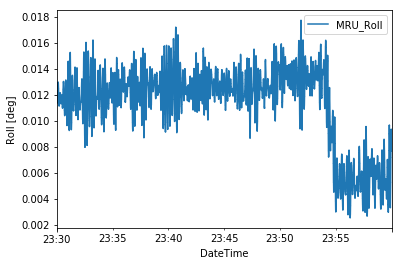

In [9]:

# plot one of the Roll vs index
mdf_object.data.plot(y=["MRU_Roll"])
plt.ylabel('Roll [deg]')
plt.show()


The reading time has dropped down to less than a second. The DateTime is implicitely imported (as we did not mention it in the filter list), so we can plot the Roll vs the date

#### Selecting the columns based on the column names and labels

In the make_report() output it can be seen that each channel in the MDF file has a unique name which is not very self-explanary (such as *BALDER_UI1_A130_VI18*) and a label with a description such as *HZ3 - AX - 03* which is the HZ3 location with the acceleration in x direction. We can also filter on the label since the filter_list argument consist of a list of regular expressions. The first regular expression is always applied on the channel *name*, whereas all the next regular expressions are applied on the channel *labels*. So we can select all the HZ3 accelerations by the following


In [10]:
mdf_object.set_column_selection(filter_list=["^BALDER", "HZ3.*A[XYZ]"])
mdf_object.import_data()
names = mdf_object.make_report(show_loaded_data_only=True)


cnt index Loaded : Name                                               : Label
--- ----- ------ : -------------------------------------------------- : ------------------------------
  0    15      1 : DateTime                                           : 
  1    57      1 : BALDER__UI1_A130_VI1                               : HZ3 - AX - 02
  2    58      1 : BALDER__UI1_A131_VI1                               : HZ3 - AY - 03
  3   111      1 : MRU_Roll                                           : Roll


So in this case we have first selected all the channels with a record name starting with `^BALDER` (the `^` symbol matches the start of a string) and from that list we have selected all the channels with a label with `HZ3.*A[XYZ]`. Note that the `.*` matches a string of arbitrary length (also empty) with any character and the part with `[XYZ]` matches the `X` of `Y` or `Z` character. So using this filter list we have now loaded the HZ3 AX and AY component (as AZ is not available). Note that the MRU_Roll component is still available from the previous round. 

We have used the *make_report()* method again to show the contents of the mdf_object data. The *show_loaded_data_only* flags is used to suppress all the columns which are available in the MDF file but have not been loaded yet. The column names in the table shown by *make_report* is returned to the *names* list. We can use this list to access the data frame column names of the column we want to use. In this case we first extract the names of the HZ3 AX and AY column which are stored in the 1 and 2 index of this names list (as you can see from the *cnt* column in the table). Get the names and plot the data

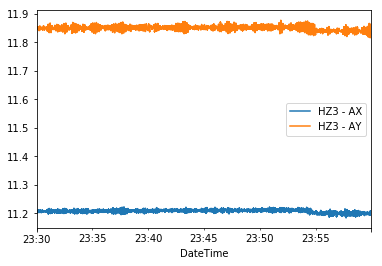

In [11]:
hz3x_name = names[1]
hz3y_name = names[2]
ax = mdf_object.data.plot(y=[hz3x_name, hz3y_name])

# this is only required to replace the default labels (which are the column names) to
# something meaning full
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines[:2], ["HZ3 - AX", "HZ3 - AY"], loc="best")
plt.show()

We can extend the *filter_list* with more labels search patterns if we want. For instance, if you want to load all the channels from the RX4 and the Tower you can do

In [12]:
mdf_object.set_column_selection(filter_list=["^BALDER", "Tower.*", "RX4"])
mdf_object.import_data()
names = mdf_object.make_report(show_loaded_data_only=True)

cnt index Loaded : Name                                               : Label
--- ----- ------ : -------------------------------------------------- : ------------------------------
  0    15      1 : DateTime                                           : 
  1    32      1 : BALDER__UI0_A105_VI1                               : RX4 - SG 05
  2    33      1 : BALDER__UI0_A106_VI1                               : RX4 - SG 06
  3    34      1 : BALDER__UI0_A107_VI1                               : RX4 - SG 07
  4    35      1 : BALDER__UI0_A108_VI1                               : RX4 - SG 08
  5    57      1 : BALDER__UI1_A130_VI1                               : HZ3 - AX - 02
  6    58      1 : BALDER__UI1_A131_VI1                               : HZ3 - AY - 03
  7    59      1 : BALDER__UI1_A132_VI1                               : RX4 - AX - 01
  8    65      1 : BALDER__UI2_A138_VI1                               : Tower Head (PS) - AX - 10
  9    66      1 : BALDER__UI2_A139_VI1               

You can see that both the SB and PS Tower channels are loaded and also the RX4. The HZ3 was loaded in the previous call already. In this way you can extend the channels being loaded.  

Remember that the first pattern in the *filter_list* (`^BALDER`) applies to the name of the record, all the following patterns apply to the labels. In case you want to select multiple columns based on the name field of the record you have to use the regular expression which `|`, which means `or`. For instance, load the latitude and longitude	

In [13]:
mdf_object.set_column_selection(filter_list=["GPS_Lat.*|GPS_Lon.*"])
mdf_object.import_data()
names = mdf_object.make_report(show_loaded_data_only=True)

cnt index Loaded : Name                                               : Label
--- ----- ------ : -------------------------------------------------- : ------------------------------
  0    15      1 : DateTime                                           : 
  1    32      1 : BALDER__UI0_A105_VI1                               : RX4 - SG 05
  2    33      1 : BALDER__UI0_A106_VI1                               : RX4 - SG 06
  3    34      1 : BALDER__UI0_A107_VI1                               : RX4 - SG 07
  4    35      1 : BALDER__UI0_A108_VI1                               : RX4 - SG 08
  5    57      1 : BALDER__UI1_A130_VI1                               : HZ3 - AX - 02
  6    58      1 : BALDER__UI1_A131_VI1                               : HZ3 - AY - 03
  7    59      1 : BALDER__UI1_A132_VI1                               : RX4 - AX - 01
  8    65      1 : BALDER__UI2_A138_VI1                               : Tower Head (PS) - AX - 10
  9    66      1 : BALDER__UI2_A139_VI1               

Now we have included the latitude and longitude column. We can display some information on the locations as follows

In [14]:
mdf_object.data[["GPS_LatitudeDez", "GPS_LongitudeDez"]].describe()

,GPS_LatitudeDez,GPS_LongitudeDez
count,45000.000000,45000.000000
mean,-6.244657,10.729433
std,0.000090,0.000139
min,-6.244780,10.729253
25%,-6.244736,10.729302
50%,-6.244671,10.729413
75%,-6.244571,10.729573
max,-6.244522,10.729637
